## The Lorenz chaotic attractor

This example shows the construction of a classic chaotic dynamical system: the Lorenz "butterfly" attractor.  The equations are:
        
$$
\dot{x}_0 = \sigma(x_1 - x_0) \\
\dot{x}_1 = x_0 (\rho - x_2) - x_1  \\
\dot{x}_2 = x_0 x_1 - \beta x_2 
$$

Since $x_2$ is centered around approximately $\rho$, and since NEF ensembles are usually optimized to represent values within a certain radius of the origin, we substitute $x_2' = x_2 - \rho$, giving these equations:
$$
\dot{x}_0 = \sigma(x_1 - x_0) \\
\dot{x}_1 = - x_0 x_2' - x_1\\
\dot{x}_2' = x_0 x_1 - \beta (x_2' + \rho)
$$

*Note that the last equation for $x_2'$ is typically shown with an error in articles from Prof. Eliasmith's group.

For more information, see http://compneuro.uwaterloo.ca/publications/eliasmith2005b.html "Chris Eliasmith. A unified approach to building and controlling spiking attractor networks. Neural computation, 7(6):1276-1314, 2005."

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-colorblind')

from matplotlib import rc, rcParams
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':7})
rc('text', usetex=True)
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath}']

import nengo
%load_ext nengo.ipynb

<IPython.core.display.Javascript object>

In [46]:
model = nengo.Network()
s_pi = 0.1
ints = [0, 1/4]
rats = s_pi * np.arange(1, 4)/2
enst = [-1,1]

num_intercepts = len(ints)
num_max_rates = len(rats)
num_encoders = len(enst) ** 2

# Constant neuron
constant_neuron = False
num_neurons = np.int_(num_encoders * num_max_rates * num_intercepts)
if constant_neuron: 
    num_neurons += 1

j = 0
encoders = np.zeros(shape=(num_neurons, 3))
intercepts = np.zeros(num_neurons)
max_rates = np.zeros_like(intercepts)
for ir in range(num_max_rates):
    for ii in range(num_intercepts):
        for ie0 in range(len(enst)):
            if ie0 is 0: 
                continue
            for ie1 in range(len(enst)):
                for ie2 in range(len(enst)):
                    vertex = np.array([enst[ie0], enst[ie1], enst[ie2]])
                    if not np.all(vertex == 0):
                        encoders[j,:] = vertex
                        intercepts[j] = ints[ii]
                        max_rates[j] = rats[ir]
                        j += 1
            
# Constant neuron
if constant_neuron:
    encoders[j,:] = [1,1,1]
    intercepts[j] = 0
    max_rates[j] = 0
    
# Print checks of the neuron parameters
row_format = "{:^15}" * (3 + 1)
print(row_format.format(*["Neuron", "Encoder", "Intercept", "Max_rates"]))
for i, (encoder, intercept, max_rate) in enumerate(zip(encoders, intercepts, max_rates)):
    # print(row_format.format(i, data[0], data[1], data[2]))
    print(row_format.format(i, np.array_str(encoder), round(intercept, 4), round(max_rate, 4)))

# Timing configuration
tau = 10 # neuron synapse timeconstant (doesn't really matter)
delayTime = .048 #0.061 # feedback delay in ps
# gamma is a characteristic time scale in real time units
# The coefficient gamma/delayTime determines the stability
# In paper, coefficient was 65 (spurious), 104 (inaccurate), 260 (looks good)
gamma = 260 * delayTime 

dt = gamma / 2000 # make sure time step is less than virtual time
dt = min(dt, tau / 100) # make sure time step is less than tau
dt = min(dt, delayTime/10) # make sure it's less than delay

# the ODE to emulate
# The default values for sigma, beta and rho originally used by Lorenz. 
# Cf. https://en.wikipedia.org/wiki/Lorenz_system#Analysis
sigma = 10.0
beta = 8.0/3
rho = 28
def feedback(x):
    dx0 = (-sigma * x[0] + sigma * x[1]) / gamma
    dx1 = (-x[0] * x[2] - x[1]) / gamma
    dx2 = (x[0] * x[1] - beta * (x[2] + rho)) / gamma
    
    return [dx0 * tau + x[0], 
            dx1 * tau + x[1], 
            dx2 * tau + x[2]]

# We'll make a simple object to implement the delayed feedback
class Delay(object):
    def __init__(self, dimensions, timesteps=50):
        timesteps = max(timesteps,1)
        self.history = np.zeros((timesteps, dimensions))
    def step(self, t, x):
        self.history = np.roll(self.history, -1, axis=0)
        self.history[-1] = x
        return self.history[0]
delay = Delay(3, timesteps=int(delayTime / dt))

with model:
    # The main ensemble
    state = nengo.Ensemble(num_neurons, dimensions=3, 
        intercepts=intercepts, 
        neuron_type=nengo.neurons.FourierSinusoid(max_overall_rate=400,s_pi=s_pi),
        max_rates=max_rates,
        encoders=encoders, radius=60.)

    # This special node calls a function every timestep, in this case a class method of delay
    delay_node = nengo.Node(delay.step, size_in=3, size_out=3)
    
    # Connections from state to delay and back
    cdel = nengo.Connection(state, delay_node)
    conn = nengo.Connection(delay_node, state, function=feedback, synapse=tau)
    
    # Probes used to examine results post-sim
    variable_probe = nengo.Probe(state, synapse=0)
    delay_probe = nengo.Probe(delay_node, synapse=0)
    state_probe = nengo.Probe(state.neurons)
    weight_probe = nengo.Probe(cdel, 'weights')

# Look at the tuning curves
# eval_points, activities = tuning_curves(state, sim)
# plt.plot(eval_points, activities, lw=2)
# plt.xlabel("Input signal")
# plt.ylabel("Firing rate (Hz)")
    
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(20 * gamma)

    Neuron         Encoder       Intercept      Max_rates   
       0        [ 1. -1. -1.]       0.0           0.05      
       1        [ 1. -1.  1.]       0.0           0.05      
       2        [ 1.  1. -1.]       0.0           0.05      
       3        [ 1.  1.  1.]       0.0           0.05      
       4        [ 1. -1. -1.]      0.25           0.05      
       5        [ 1. -1.  1.]      0.25           0.05      
       6        [ 1.  1. -1.]      0.25           0.05      
       7        [ 1.  1.  1.]      0.25           0.05      
       8        [ 1. -1. -1.]       0.0            0.1      
       9        [ 1. -1.  1.]       0.0            0.1      
      10        [ 1.  1. -1.]       0.0            0.1      
      11        [ 1.  1.  1.]       0.0            0.1      
      12        [ 1. -1. -1.]      0.25            0.1      
      13        [ 1. -1.  1.]      0.25            0.1      
      14        [ 1.  1. -1.]      0.25            0.1      
      15        [ 1.  1.

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


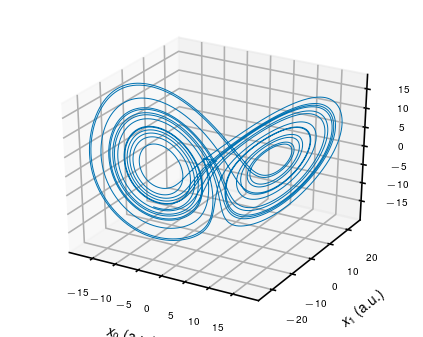

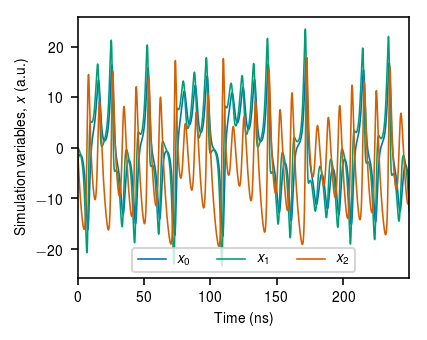

In [47]:
from mpl_toolkits.mplot3d import Axes3D
saving = False

if saving:
    pp = PdfPages('lorenz_system_3d.pdf')
fig = plt.figure(0, figsize=(3,2.4), dpi=72)
ax = fig.add_subplot(111, projection='3d')
dat3d = (sim.data[variable_probe][:, dim] for dim in range(3))
ax.plot(*dat3d, linewidth = 0.5)
ax.set_xlabel('$x_0$ (a.u.)')
ax.set_ylabel('$x_1$ (a.u.)')
ax.set_zlabel('$x_2$ (a.u.)')
for xlabel_i in ax.get_xticklabels():
    xlabel_i.set_fontsize(5.0)
for ylabel_i in ax.get_yticklabels():
    ylabel_i.set_fontsize(5.0)
for zlabel_i in ax.get_zticklabels():
    zlabel_i.set_fontsize(5.0)

plt.tight_layout()
if saving:
    pp.savefig()
    pp.close()
    pp = PdfPages('lorenz_time_traces.pdf')
fig = plt.figure(1, figsize=(3,2.4), dpi=72)
for variable, label in zip(sim.data[variable_probe].T, ['$x_0$', '$x_1$', '$x_2$']):
    plt.plot(sim.trange(), variable, label=label, linewidth = 0.8)
# for dvar in sim.data[delay_probe].T:
#     plt.plot(sim.trange(), dvar)
plt.legend(bbox_to_anchor=(0., .02, 1., .102), loc='lower center',
           ncol=3, borderaxespad=0.)
plt.xlabel('Time (ns)')
plt.ylabel('Simulation variables, $x$ (a.u.)')
plt.tight_layout()
plt.xlim((0,max(sim.trange())))
# plt.ylim(15*np.array([-1,1]))
if saving:
    pp.savefig()
    pp.close()

In [48]:
# Export data
import scipy.io as sio
# For Alex's local
# dataDir = '/Users/AlexTait/Dropbox/Documents/MATLAB/lorenzEmulator/ctrnn data/'
# For this Repo
dataDir = 'lightwave_stuff/discreteTimeLorenzFiles/ctrnn data/'
fname = dataDir + 'lorenz_signals.mat'
sio.savemat(fname, {'time':sim.trange(), 'x':sim.data[variable_probe].T})
sio.whosmat(fname)

[('time', (1, 52000), 'double'), ('x', (3, 52000), 'double')]

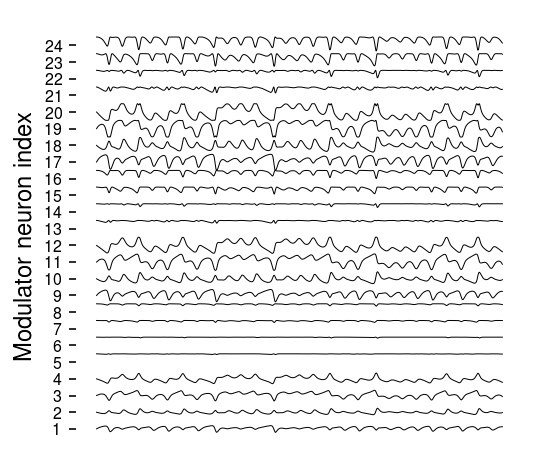

In [49]:
saving = False
if saving:
    pp = PdfPages('MZM_time_traces.pdf')
fig = plt.figure(2, figsize=(4,4), dpi=72)
ax = plt.gca()

cm = plt.get_cmap('Paired') 
cNorm  = colors.Normalize(vmin=0, vmax=num_neurons)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
for i in range(num_neurons):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(sim.trange()*1e-3, sim.data[state_probe][:, i]/400 + (i+.5), lw=.5, color='k')
# plt.xlabel('Real time (us)')
plt.ylabel('Modulator neuron index', fontsize=12)
plt.xticks([])
plt.yticks(1 + np.arange(num_neurons))
ax.set_yticklabels(ax.get_yticks(), fontsize=8)
for s in ax.spines:
    ax.spines[s].set_visible(False)

if saving:
    pp.savefig()
    pp.close()

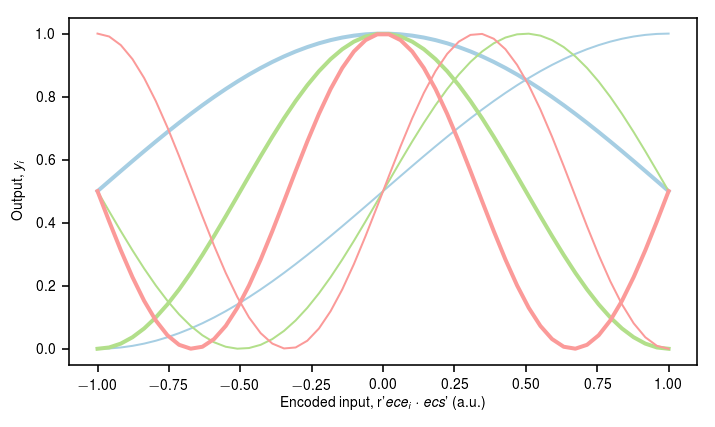

In [6]:
from nengo.utils.ensemble import tuning_curves
from nengo.utils.ensemble import response_curves

saving = False

# Thomas version using tuning_curves

#1D encoders
# model = nengo.Network()
# with model:
#     num_neurons = np.int_(3*5)
#     encoders = np.tile([[1]], (np.int_(num_neurons),1))
#     intercepts = np.tile([-0.5,0,0.5], np.int_(num_neurons/3))
#     max_rates = np.tile([0,0.5,1,1.5,2], np.int_(num_neurons/5))
#     state = nengo.Ensemble(num_neurons, dimensions=1, intercepts=intercepts, neuron_type=nengo.neurons.FourierSinusoid(max_overall_rate=1),
#                        max_rates=max_rates,
#                        encoders=encoders, radius=60.)
#     state_probe = nengo.Probe(state)
    
# with nengo.Simulator(model) as sim:
#     eval_points, activities = tuning_curves(state, sim)

# Alex version
eval_points, responses = response_curves(state, sim)
if num_neurons != np.shape(responses)[1]:
    raise Exception('Number of neurons(' + str(num_neurons) + ') and response curves(' + str(np.shape(responses)[1]) + ') is inconsistent')

if saving:
    pp = PdfPages('tuning_curves.pdf')
fig = plt.figure(2, figsize=(5,3), dpi=72)
# jet = cm = plt.get_cmap('winter') 
# cNorm  = colors.Normalize(vmin=0, vmax=(num_neurons-1)/2)
cm = plt.get_cmap('Paired') 
cNorm  = colors.Normalize(vmin=0, vmax=12.01)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
for i in range(0, int(num_neurons/num_encoders), 2):
    colorVal = scalarMap.to_rgba(i+1)
    plt.plot(eval_points, responses[:,i*(num_encoders)]/400, lw=1, color=colorVal)
    colorVal = scalarMap.to_rgba(i+1)
    plt.plot(eval_points, responses[:,(i+1)*(num_encoders)]/400, lw=2, color=colorVal)
plt.xlabel("Encoded input, r'$\vec{e}_i \cdot \vec{s}$' (a.u.)")
plt.ylabel("Output, $y_i$")
plt.tight_layout()
if saving:
    pp.savefig()
    pp.close()

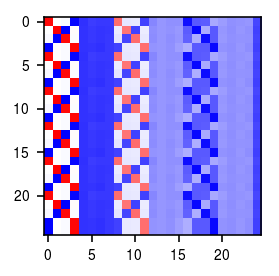

In [7]:
# The weight probe is sim.data[weight_probe][0,:,:], but that gives the best approx to (x0, x1, x2)
# What we actually want is the interconnection matrix.
# For that, you need to encode this vector using the encoders variable.
weight_matrix = np.dot(encoders, sim.data[weight_probe][0,:,:])

saving = True
if saving:
    pp = PdfPages('weight_matrix.pdf')
fig = plt.figure(3, figsize=(2,2), dpi=72)
plt.imshow(weight_matrix, cmap='bwr', interpolation='nearest')
if saving:
    pp.savefig()
    pp.close()